In [1]:
import requests 
from dashboard_configs import league_id
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Step 1 get all the users in a given league
endpoint = f'https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/'
response = requests.get(endpoint).json()
standings = pd.DataFrame(response['standings']['results'])

In [3]:
standings.head()

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name
0,10303098,39,Niklas Wietzorrek,1,1,1,185,1742534,CanceloCulture
1,11191718,42,Liam Smorfitt,2,4,2,172,1930701,PK fc
2,62382206,38,Cam Jacobsz,3,2,3,171,2122857,BringBackDaMane
3,44640726,38,Jason Perry,4,5,4,165,3648627,Change Name
4,42326189,52,Peter Wertz,5,12,5,164,2123591,Alfa Romeu


In [4]:
#Step 2a get favourite club names and ID'sandbox.ipynb
endpoint = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(endpoint).json()
teams = pd.DataFrame(response['teams']).iloc[:, [3,5]]

In [5]:
teams.rename(columns = {'id':'club_id', 'name':'club'}, inplace = True)
teams.head()

,club_id,club
0,1,Arsenal
1,2,Aston Villa
2,3,Bournemouth
3,4,Brentford
4,5,Brighton


In [6]:
# Step 2b get each managers information 
# manager_id = 6896205
# endpoint = f' https://fantasy.premierleague.com/api/entry/{manager_id}/'
# response = requests.get(endpoint).json()
# favourite_team = response['favourite_team']
# manager_region = response["player_region_name"]

In [7]:
manager_ids = []
manager_clubs = []
manager_regions = []
for i in standings.entry:
    endpoint = f' https://fantasy.premierleague.com/api/entry/{i}/'
    response = requests.get(endpoint).json()
    favourite_club_id = response['favourite_team']
    region = response["player_region_name"]
    manager_ids.append(i)
    manager_clubs.append(favourite_club_id)
    manager_regions.append(region)

favourite_clubs_df = pd.DataFrame({'entry_id': manager_ids, 'club_id':manager_clubs, 'region': manager_regions})

In [8]:
standings = pd.merge(standings, favourite_clubs_df, left_on='entry', right_on='entry_id', how='left').drop('entry_id', axis=1)
standings = pd.merge(standings, teams, on="club_id", how="left")

In [9]:
standings.head()

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name,club_id,region,club
0,10303098,39,Niklas Wietzorrek,1,1,1,185,1742534,CanceloCulture,12.0,South Africa,Liverpool
1,11191718,42,Liam Smorfitt,2,4,2,172,1930701,PK fc,14.0,South Africa,Man Utd
2,62382206,38,Cam Jacobsz,3,2,3,171,2122857,BringBackDaMane,12.0,South Africa,Liverpool
3,44640726,38,Jason Perry,4,5,4,165,3648627,Change Name,14.0,South Africa,Man Utd
4,42326189,52,Peter Wertz,5,12,5,164,2123591,Alfa Romeu,17.0,South Africa,Southampton


In [10]:
favourite_clubs = standings.club.value_counts()
regions = standings.region.value_counts()

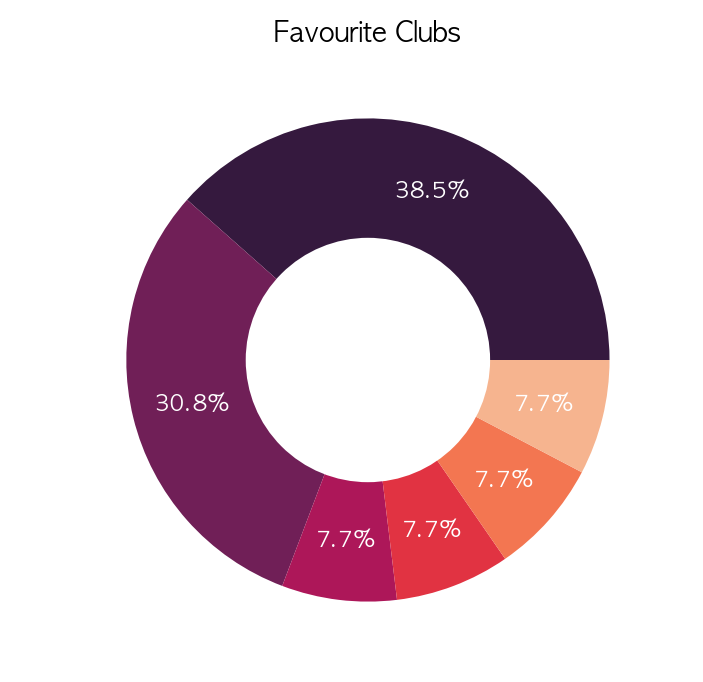

In [11]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams.update({'font.size': 8})

vals = favourite_clubs.values

clubs = favourite_clubs.index

num = len(favourite_clubs.index)

# Seaborn color palette to plot pie chart
colors = sns.color_palette('rocket',num)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.5, color='white')

# create pie chart using matplotlib
plt.title('Favourite Clubs')
plt.pie(vals, labels=clubs, colors=colors, autopct='%1.1f%%', pctdistance=0.75, textprops={'color':"w"})
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

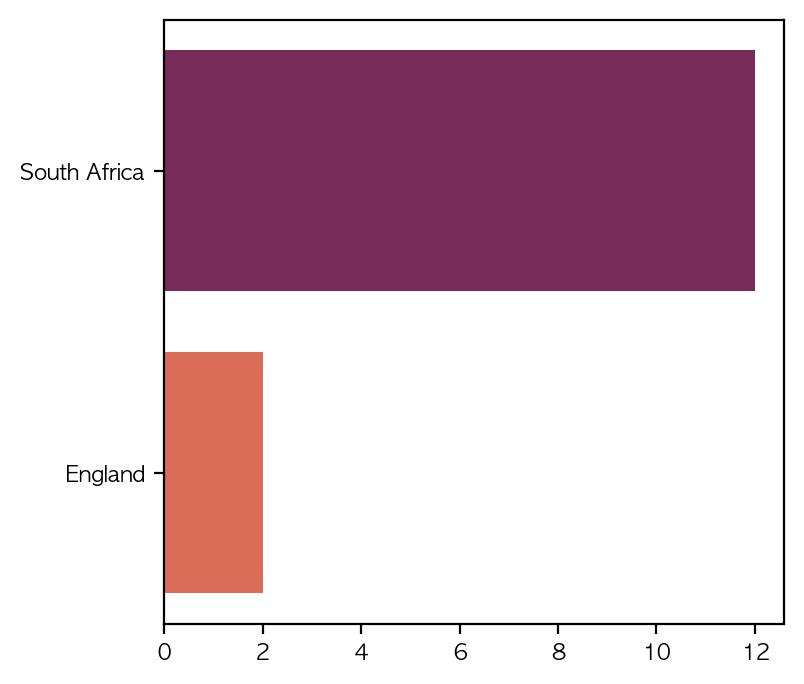

In [12]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams.update({'font.size': 8})

vals = regions.values

countries = regions.index

num = len(vals)

# Seaborn color palette to plot pie chart
colors = sns.color_palette('rocket',num)

sns.barplot(x=vals,y=countries, palette=colors)
plt.show()

In [13]:
# #TC 
# # 721791
# # manager_id = 3633274


# #BB AND TC
# manager_id = 6209589

# # free hit

# # manager_id = 6518355

# endpoint = f'https://fantasy.premierleague.com/api/entry/{manager_id}/history/'
# response = requests.get(endpoint).json()
# chips = response['chips']
# season = response['current']


In [14]:
season_df = pd.DataFrame()

for i in standings.entry:

    endpoint = f'https://fantasy.premierleague.com/api/entry/{i}/history/'
    response = requests.get(endpoint).json()
    season = response['current']
    temp_season_df = pd.DataFrame(season)

    m_id = []
    for j in range(len(season)):
        m_id.append(i)

    temp_season_df['entry'] = m_id

    season_df = season_df.append(temp_season_df, ignore_index=True)

    
season_df = pd.merge(season_df, standings[['entry','player_name']], on="entry", how="left")




In [15]:
max_pts = season_df.points.max()
max_pts_manager = season_df.loc[season_df['points'] == max_pts, 'player_name'].values
max_pts_manager = max_pts_manager[0]

In [16]:
sum_df = season_df.groupby('player_name').sum()
sum_df['points_bench_incl'] = sum_df.points + sum_df.points_on_bench
max_bench_pts = sum_df.points_on_bench.max()
max_bench_pts_manager = sum_df.loc[sum_df['points_on_bench'] == max_bench_pts].index


most_hits = sum_df.event_transfers_cost.max()
most_hits_manager = sum_df.loc[sum_df['event_transfers_cost'] == most_hits].index
most_hits_num = most_hits/4
most_hits_manager[0]
most_hits_num

sorted_by_bench = sum_df.sort_values(by='points_bench_incl', ascending=False).iloc[:, -1]

In [17]:
season_df.head()

,event,points,total_points,rank,rank_sort,overall_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,entry,player_name
0,1,68,68,1725839,1784744,1725838,0,1000,0,0,4,1742534,Niklas Wietzorrek
1,2,78,146,624576,634628,390415,0,1002,0,0,11,1742534,Niklas Wietzorrek
2,3,39,185,4528004,4546636,547363,4,1009,2,0,11,1742534,Niklas Wietzorrek
3,1,59,59,3699295,3753568,3699292,0,1000,0,0,3,1930701,Liam Smorfitt
4,2,71,130,1512043,1532189,1824558,0,1001,0,0,14,1930701,Liam Smorfitt


In [18]:
season_df.sort_values(by='overall_rank')

,event,points,total_points,rank,rank_sort,overall_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,entry,player_name
1,2,78,146,624576,634628,390415,0,1002,0,0,11,1742534,Niklas Wietzorrek
2,3,39,185,4528004,4546636,547363,4,1009,2,0,11,1742534,Niklas Wietzorrek
18,1,71,71,1227564,1270746,1227564,5,1000,0,0,2,2032628,HetheB Ninja
36,1,71,71,1227564,1274134,1227564,0,1000,0,0,3,2208836,Divyam Dixit
16,2,70,133,1773481,1780209,1526573,3,1000,1,0,11,534613,Connor McDonald
7,2,78,133,673990,684227,1526573,10,1000,1,0,18,2122857,Cam Jacobsz
5,3,42,172,3499714,3517922,1593235,0,1006,1,0,5,1930701,Liam Smorfitt
8,3,38,171,4773092,4796923,1723949,5,1002,1,0,8,2122857,Cam Jacobsz
0,1,68,68,1725839,1784744,1725838,0,1000,0,0,4,1742534,Niklas Wietzorrek
12,1,68,68,1725839,1796175,1725838,0,1000,0,0,8,2123591,Peter Wertz


In [19]:
best_rank = season_df.overall_rank.min()
best_rank_manager = season_df.loc[season_df['overall_rank'] == best_rank, 'player_name'].values
best_rank_gw = season_df.loc[season_df['overall_rank'] == best_rank, 'event'].values
best_rank_manager[0]
best_rank_gw[0]

2

In [20]:
std_df = season_df.iloc[:, [1,5,-1]].groupby('player_name').std()
min_std = std_df.points.min()
min_std_manager = std_df.loc[std_df['points'] == min_std].index.values
min_std_manager[0]

'Devon Jansen'

In [21]:
#single GW
most_b_points = season_df.points_on_bench.max()
most_b_points_manager = season_df.loc[season_df['points_on_bench'] == most_b_points, 'player_name'].values
most_b_points_gw = season_df.loc[season_df['points_on_bench'] == most_b_points, 'event'].values
most_b_points_gw[0]
most_b_points_manager[0]

'Cole Floyd'

In [22]:
TC = []
BB = []
FH = []
ids = []
for i in standings.entry:
    endpoint = f'https://fantasy.premierleague.com/api/entry/{i}/history/'
    response = requests.get(endpoint).json()
    chips = response['chips']
    season = response['current']

    if len(chips) == 0:
        TC.append(0)
        BB.append(0)
        FH.append(0)
        ids.append(i)

    else:
        for j in chips:
            if j['name'] == '3xc':
                TC.append(1)
            else:
                TC.append(0)

            if j['name'] == 'bboost':
                BB.append(1)
            else:
                BB.append(0)

            if j['name'] == 'freehit':
                FH.append(1)
            else:
                FH.append(0)

            ids.append(i)

chip_df =pd.DataFrame({'m_id': ids, 'used_tc': TC, 'used_bb': BB, 'used_fh': FH})



In [23]:
standings = pd.merge(standings, chip_df, left_on='entry', right_on='m_id', how='left').drop('m_id', axis=1)

In [24]:
standings

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name,club_id,region,club,used_tc,used_bb,used_fh
0,10303098,39,Niklas Wietzorrek,1,1,1,185,1742534,CanceloCulture,12.0,South Africa,Liverpool,1,0,0
1,11191718,42,Liam Smorfitt,2,4,2,172,1930701,PK fc,14.0,South Africa,Man Utd,0,0,0
2,62382206,38,Cam Jacobsz,3,2,3,171,2122857,BringBackDaMane,12.0,South Africa,Liverpool,0,0,0
3,44640726,38,Jason Perry,4,5,4,165,3648627,Change Name,14.0,South Africa,Man Utd,0,0,0
4,42326189,52,Peter Wertz,5,12,5,164,2123591,Alfa Romeu,17.0,South Africa,Southampton,0,0,0
5,11045904,22,Connor McDonald,6,2,6,155,534613,Darwin Award,12.0,South Africa,Liverpool,0,0,0
6,11593605,46,HetheB Ninja,6,13,7,155,2032628,Obi Wan-Bassaka,14.0,South Africa,Man Utd,0,0,0
7,11044918,35,Alex Wietzorrek,8,9,8,154,560769,Shake ‘n Bake,NaN,South Africa,NaN,0,0,1
8,11604984,36,Marco Gouveia,9,6,9,154,552345,Neves Say Never,1.0,South Africa,Arsenal,0,0,0
9,42389877,31,Ryan Shacks,10,8,10,151,578302,Dier Straits,18.0,South Africa,Spurs,0,0,0
